## Introduction

The main goal in this project is to come up with the best model that can predict the clients defaulting behavior.
<br>The UCI Credit Card dataset will be used[1]. Since the dataset is unbalance with the rate of positive class = 0.22 using the accuracy as an evaluation metric can be missleading. Therefore, the Area Under the Curve AUC will be used instead.
To ensure the robustness of the selected best model, a 5-fold CV will be used first for selecting the best model out of a given Hypothesis set. Then the performance of best overall classifier will be tested for generalizaiton using an unseen test set.
<br>The following Hypothesis sets will be used:
<br>1- L2 regularized logistic regression
<br>2- Neural network
<br>3- Random forest
<br>4- XGBoost

### Importing needed packages and functions

In [ ]:
%matplotlib inline
import os
import pickle
import dill
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.contrib.tensorboard.plugins import projector

### Helper functions 

In [15]:
def save_obj(model, filename):
    """output an object to file
    Args:
        model: An object to save
        filename: A string used to name the file including directory
    """
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
        
def load_obj(filename):
    """load an object from file
    Args:
        filename: A string represents filename inculuding directory
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def plot_class_dist(data, labels = None):
    """ Plot the distributaion for the classes
    Args:
        data: A numpy vector containing the class data
        labels: optional labels to display for each class. if none
                numbers from 0 to num class -1 will be used
    """
    label_count = np.unique(data, return_counts = True)
    fig = plt.figure()
    ax = fig.gca()   
    ax.set_xticks(label_count[0])
    if labels:        
        ax.set_xticklabels(labels, rotation='horizontal')
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Class')
    plt.title('Class Distribution')
    plt.bar(x = label_count[0], height = label_count[1]/data.shape[0])
    plt.grid()
    plt.show()
    
def ensure_dir(file_path):
    """Ensure that the directory given by filt_path exists if not it creates it
    
    Args:
        file_path: A tring representing the directory to ensure
      
    """
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def generate_batch(X, y, batch_size, shuffle = True):
    """ Generate batch while keeping the same ratio between the two classes

    Args:
        X (numpy array): Design matrix [num_samples, num_features]
        y (numpy array): Class Labels [num_samples, 1]
        batch_size (int): number of samples per batch
        shuffle (bool): True for shuffling the samples
 
    Returns:
        (numpy array): A single batch representing the augmentd data label array with shape
        [batch_size, num_features + 1]

    """
    #if the labels are one dimensional vector add a new dimension
    if y.ndim ==1:
        y=y[:,np.newaxis]
        
    N, n_feats = X.shape
    data = np.c_[X, y]

    if shuffle:
        np.random.shuffle(data)

    pos_class = data[data[:,-1] == 1]
    neg_class = data[data[:,-1] == 0]
    neg_per_batch = math.floor(batch_size*neg_class.shape[0]/data.shape[0])
    pos_per_batch = batch_size - neg_per_batch
    n_batches = math.ceil( data.shape[0] / batch_size)
    start_pos = 0
    start_neg = 0

    for i in range(n_batches):        
        if ((i+1)*neg_per_batch <neg_class.shape[0]) and ((i+1)*pos_per_batch < pos_class.shape[0]):
            data2 = np.concatenate((neg_class[start_neg: (i+1)*neg_per_batch,:],
                                    pos_class[start_pos: (i+1)*pos_per_batch,:]))
            start_pos = (i+1)*pos_per_batch
            start_neg = (i+1)*neg_per_batch
        elif ((i+1)*neg_per_batch < neg_class.shape[0]) and ((i+1)*pos_per_batch > pos_class.shape[0]):
            data2 = np.concatenate((neg_class[start_neg: (i+1)*neg_per_batch,:],
                                    pos_class[start_pos: ,:]))
            start_pos = pos_class.shape[0]
            start_neg = (i+1)*neg_per_batch

        elif ((i+1)*neg_per_batch > neg_class.shape[0]) and ((i+1)*pos_per_batch < pos_class.shape[0]):
            data2 = np.concatenate((neg_class[start_neg: ,:],
                                    pos_class[start_pos: (i+1)*pos_per_batch,:]))
            start_pos = (i+1)*pos_per_batch
            start_neg = neg_class.shape[0]
        else:
            data2 = np.concatenate((neg_class[start_neg: ,:],
                                    pos_class[start_pos: ,:]))
            start_pos = pos_class.shape[0]
            start_neg = neg_class.shape[0]
                
        yield data2

def plot_confusion_matrix(c_matrix, percentage = True, labels = None):
    """Plot the confusion matrix    
    
    Args:
        c_matrix (numpy array): confusion matrix [num_classes, num_classes]
        percentage (bool): True plot confucion matrix elements as a percentage
                           of their true values
        labels (list): list containing the class labels  
    """
    if percentage:
        c_matrix = c_matrix.astype(np.float32)
        c_matrix = c_matrix/np.sum(c_matrix, axis = 1, keepdims = True)
    if labels:
        df_matrix = pd.DataFrame(data = c_matrix, index = labels, columns = labels)
    else:
        df_matrix = pd.DataFrame(data = c_matrix, index = np.arange(c_matrix.shape[0]), 
                                 columns = np.arange(c_matrix.shape[0]))
    
    plt.title('Confusion Matrix')
    sns.heatmap(data = df_matrix, annot = True)    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
    
def fully_connected_layer(X, **kwargs):
    """create a TF dense layer     
    
    Args:
        X (Tensor): Input Tensor [batch_size, num_features]
        num_out_units (int): The number of output units of the dense layer
        activation (function): The output activation function
        shuffle (bool): True for shuffling the samples
        regularizer: Type of regularizer to use
        drop_out (bool): True for applying drop out
        keep_prob (float): The probabilty of keeping a unit on during training,
                            if drop_out is True
        batch_norm (bool): True for applying batch normalization
        training (bool): True Layer is used in training mode
        summary (bool): True to include histogram information about the layer
                        and use it for tensorboard summary
        name (str): layer name                
    Returns:
        (Tensor): A tensor representing the layer output [batch_size, num_out_units]

    """

    #Args default values for
    args = {'num_out_units' : 1, 'activation' : None, 'regularizer' : None, 
               'keep_prob' : 1, 'name' : 'FC_layer', 'batch_norm' : False, 
               'training' : False, 'drop_out' : False, 'summary' : True}
    
    args.update(kwargs)
    with tf.variable_scope('{}'.format(args['name']), reuse=None) as scope:
        layer = tf.contrib.layers.fully_connected(X, args['num_out_units'],
                                                  activation_fn = None,
                                                  weights_regularizer = args['regularizer'])
                
        if args['batch_norm']:
            layer = tf.layers.batch_normalization(layer, 
                                                  training = args['training'], 
                                                  momentum=0.9)
        if args['activation']:
            layer = args['activation'](layer)
        
        if args['summary']:    
            layer_vars = tf.get_collection(key = tf.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)                
            tf.summary.histogram("Weights_layer_{}".format(args['name']), layer_vars[0])
            tf.summary.histogram("Biases_layer_{}".format(args['name']), layer_vars[1])
            tf.summary.histogram("Activation_layer_{}".format(args['name']), layer)
        
        if(args['drop_out']):
            return tf.nn.dropout(layer, args['keep_prob'])
        else: 
            return layer

Loading the data

In [7]:
df = pd.read_csv('UCI_Credit_Card.csv')

In [43]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Generate simple information and statistics about the data, and check for missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

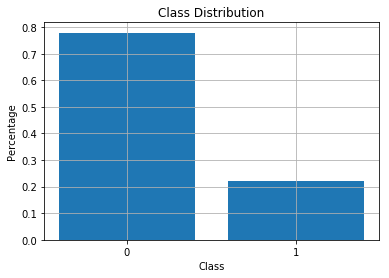

In [16]:
df.info()
df.describe(include = 'all')
plot_class_dist(df['default.payment.next.month'])

As can be seen from the info summary of the dataset, there is no missing values

### Data preperation

In [6]:
#removing the ID feature
df.drop('ID', axis = 1, inplace = True)
#Just to make things clearer the features names changed to a shorter version
new_cols = ['LIM', 'SEX', 'EDU', 'MAR', 'AGE', 'PAY1', 'PAY2',
            'PAY3', 'PAY4', 'PAY5', 'PAY6', 'BILL1', 'BILL2',
            'BILL3', 'BILL4', 'BILL5', 'BILL6', 'AMT1',
            'AMT2', 'AMT3', 'AMT4', 'AMT5', 'AMT6',
            'Label']
df.columns = new_cols

#SEX feature changed to {0,1} for male and female. 
df['SEX'] = df['SEX'] - 1

#all unkown eduacation features are set to 0 value
edu_other = [4,5,6]
for i in edu_other:
   df.loc[df['EDU'] == i, 'EDU'] = 0

### Feature Engineering

Modifying repayment features, since the distance between using revolving credit and
and delay of the payment is not defined. So pay features will be starting from 0
represent paying duly (0 months of delay) and it increases represents the delay
use of revolving credit will be a new feasture [PAYX_R]

In [8]:

pay_feat = ['PAY1','PAY2', 'PAY3', 'PAY4', 'PAY5', 'PAY6']
pay_feat2 = []
for i in pay_feat:    
    name = '{}_{}'.format(i, 'R')
    df[name] = 1*(df[i] == 0)
    df.loc[df.loc[:,i] < 0, i] = 0
    pay_feat2.append(name)    

### Adding new features
<br>1-CREDIT_UTILIZATION: bill to limit ration per month
<br>2-total number of months with unresolved DELAY
<br>3-successive number of months with unresolved delay starting from the last month [August] and going back

In [9]:
bill_feat = ['BILL1', 'BILL2', 'BILL3', 'BILL4', 'BILL5', 'BILL6']
for i in range(len(bill_feat)):
    df['CREDIT_UTILIZATION{}'.format(i)] = df[bill_feat[i]]/df['LIM']
    
df['DELAY'] = np.sum(df[pay_feat] > 0, axis = 1)    

df[pay_feat] > 0
df['RECENT DELAY'] = 0
for row in range(df.shape[0]):
    temp = []
    for feat in pay_feat:
        if df.loc[row, feat] > 0:
            temp.append(1)
        elif temp:
            df.loc[row, 'RECENT DELAY'] = np.sum(temp)
            break
        else:
            break
amt_feat = ['AMT1','AMT2', 'AMT3', 'AMT4', 'AMT5', 'AMT6']

Using dummy encoding for categorical features namely Education and Marriage

In [10]:
df = pd.get_dummies(df, columns = ['EDU', 'MAR'], drop_first = True)

In [11]:
#Reordering the features
numerical_feats = amt_feat + bill_feat + ['LIM', 'AGE']
cat_feats = [feat for feat in df.columns if feat != 'Label' and feat not in numerical_feats]
df = df[numerical_feats + cat_feats + ['Label']]
feats = list(df.columns[:-1])


In [12]:
df.head()

,AMT1,AMT2,AMT3,AMT4,AMT5,AMT6,BILL1,BILL2,BILL3,BILL4,...,CREDIT_UTILIZATION5,DELAY,RECENT DELAY,EDU_1,EDU_2,EDU_3,MAR_1,MAR_2,MAR_3,Label
0,0.0,689.0,0.0,0.0,0.0,0.0,3913.0,3102.0,689.0,0.0,...,0.000000,2,2,0,1,0,1,0,0,1
1,0.0,1000.0,1000.0,1000.0,0.0,2000.0,2682.0,1725.0,2682.0,3272.0,...,0.027175,2,0,0,1,0,0,1,0,1
2,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,29239.0,14027.0,13559.0,14331.0,...,0.172767,0,0,0,1,0,0,1,0,0
3,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,46990.0,48233.0,49291.0,28314.0,...,0.590940,0,0,0,1,0,1,0,0,0
4,2000.0,36681.0,10000.0,9000.0,689.0,679.0,8617.0,5670.0,35835.0,20940.0,...,0.382620,0,0,0,1,0,1,0,0,0


Splitting the data into training and validation [80%] and fianl test sets[20%]

In [13]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values.reshape(-1,1)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)
df_tr = pd.DataFrame(np.concatenate((X_tr, y_tr),axis = 1), columns = df.columns)

Visualizing the features distribution for both classes using training set

In [ ]:
for feat in df_tr.columns[:-1]:
    fig = plt.figure(figsize = (16, 10))
    plt.suptitle("{} Distribution".format(feat))
    plt.subplot(1,2,1)
    sns.distplot(df_tr.loc[df_tr['Label'] == 0, feat], kde = False)
    plt.title("Class 0")
    plt.subplot(1,2,2)
    sns.distplot(df_tr.loc[df_tr['Label'] == 1, feat], kde = False)
    plt.title("Class 1")

### Data Standardization 

Create a normalized version of the data sets using training set as a reference. This version will be used to train classifiers that can not handle wide variation of the ranges of each feature, such as logistic regresion and neural network

In [15]:
# standarizing the data to zero mean unit variance 
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
#X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
#augmented version of the data
X_tr_aug = np.concatenate((np.ones((X_tr_s.shape[0], 1)), X_tr_s), axis = 1)
X_test_aug = np.concatenate((np.ones((X_test_s.shape[0], 1)), X_test_s), axis = 1)

### Methodology
<br>Now we start the training process. where We will choose the best hypothesis [hg] from
the following hypothesis sets [H]: 
<br>1-L2 regularized logistic regression classifier
<br>2-Neural Network 
<br>3-Random Forest
<br>4-XGBoost

5-fold cross-validation is used to select the best model from a given hypothesis se
.Then, by comparing the best models scores, the best overall model will be chosen.
Also, the performance of the best model will be evaluated on a separate test set, 
and a generalization bound for AUC will be calculated

Also, To reduce the chanve of overfitting the best model is chosen based on early stopping criterion, where the best model is chosen as the first epoch in which
the val AUC (rounded to 4 decimal digits) equal max val AUC rounded the same way


Note: a weighted loss according to class percentage is used for training all the models

### L2 regularized logistic regression classifier

In [19]:
#k fold cross validation split indices
k = 5
skf = StratifiedKFold(n_splits = k, random_state = 0, shuffle = True)
#to adjust for class imbalance
pos_loss_weight = np.sum(y_tr == 0)/np.sum(y_tr == 1)
n_feats = X_tr.shape[1]
cwd = os.getcwd()

In [280]:
batch_size = 512
#Create the computaional graph for logistic regression
tf.reset_default_graph()
graph_lr = tf.Graph()
with graph_lr.as_default() as graph:
    with tf.variable_scope('logistic_reg', reuse = None) as scope_lr:    
        X_ph_aug = tf.placeholder(dtype = tf.float64, shape = [None, n_feats+1 ], name = 'input')    
        y_ph = tf.placeholder(dtype = tf.float64, shape = [None, 1], name = 'label')    
        w = tf.Variable(tf.random_normal(shape = [n_feats + 1, 1], stddev = 0.01, mean = 0,
                                         dtype = tf.float64), name = 'w')
        reg_lambda = tf.placeholder(dtype = tf.float64, shape = [])
        logits = X_ph_aug @ w 
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets = y_ph, logits = logits,
                                                                       pos_weight = pos_loss_weight))
        #reg_loss_l1 = loss +  reg_lambda *tf.reduce_sum(tf.abs(w))
        reg_loss_l2 = loss + reg_lambda * tf.transpose(w) @ w
        learning_rate = tf.placeholder(dtype = tf.float32, shape = [])
        optimizer = tf.train.AdamOptimizer(learning_rate)
        #training_ops_l1 = optimizer.minimize(loss = reg_loss_l1)
        training_ops_l2 = optimizer.minimize(loss = reg_loss_l2)
        p_lr = tf.sigmoid(logits)
        y_hat = tf.cast(tf.greater_equal(p_lr, 0.5), tf.float64) 
        accuracy = tf.reduce_mean(tf.cast(tf.equal(y_hat, y_ph), tf.float64))
        #accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
        #loss_summary = tf.summary.scalar('Total_Loss', tf.squeeze(reg_loss_l2))
        #merged_summary = tf.summary.merge_all() 
        saver_lr = tf.train.Saver(max_to_keep = 1000)
        init_lr = tf.global_variables_initializer()

In [281]:
n_epoches = 35
#L2 regularization constant grid 
l2_lambda = np.concatenate((np.array([0]),np.logspace(-4, -1, 4))).astype(np.float64)
loss_train_lr = np.zeros((l2_lambda.shape[0], n_epoches, k))
loss_val_lr  = np.zeros(loss_train_lr.shape)
auc_train_lr  = np.zeros(loss_train_lr.shape)
auc_val_lr  = np.zeros(loss_train_lr.shape)
pred_dir = '{}/Logistc_Reg/'.format(cwd)
ensure_dir('{}'.format(pred_dir))

In [282]:
with tf.Session(graph = graph_lr) as sess:     
    for i in range(len(l2_lambda)):
        l = 0
        for train_index, test_index in skf.split(X_tr_aug, y_tr.squeeze()): 
            tf.set_random_seed(1)
            n_batches = math.ceil( y_tr[train_index].shape[0] / batch_size)
            sess.run(init_lr)
            for epoch in range(n_epoches):
                batch = generate_batch(X_tr_aug[train_index], y_tr[train_index], batch_size, 
                                       shuffle = True)
                N = X_tr_aug[train_index].shape[0]
                for j in range(n_batches):
                    data = next(batch)
                    sess.run(training_ops_l2, feed_dict = {X_ph_aug: data[:,:-1], 
                                                           y_ph: data[:,-1].reshape(-1,1),
                                                            reg_lambda: l2_lambda[i], 
                                                           learning_rate: 0.0005})

                p_train, loss_train_lr[i, epoch, l] = sess.run([p_lr, reg_loss_l2], 
                                                      feed_dict = {X_ph_aug: X_tr_aug[train_index],
                                                                   y_ph: y_tr[train_index],
                                                                   reg_lambda: l2_lambda[i]})                        
                p_test, loss_val_lr[i, epoch, l]  = sess.run([p_lr, reg_loss_l2], 
                                                    feed_dict = { X_ph_aug : X_tr_aug[test_index], 
                                                                 y_ph: y_tr[test_index],
                                                                 reg_lambda: l2_lambda[i]})                   
                auc_train_lr[i, epoch, l] = roc_auc_score(y_true = y_tr[train_index], y_score = p_train,
                                                          average = 'weighted')
                auc_val_lr[i, epoch, l] = roc_auc_score(y_true = y_tr[test_index], y_score = p_test,
                                                        average = 'weighted')
                #for saving the model
                saver_lr.save(sess, '{}/model_lr_l2_{}_epoch_{}'.format(pred_dir, i, epoch))
            l+=1

AUC train =  0.7681543929894885
AUC validation =  0.7658282659367501
Best L2 Lambda = 0.001, Best Epoch to stop training = 28


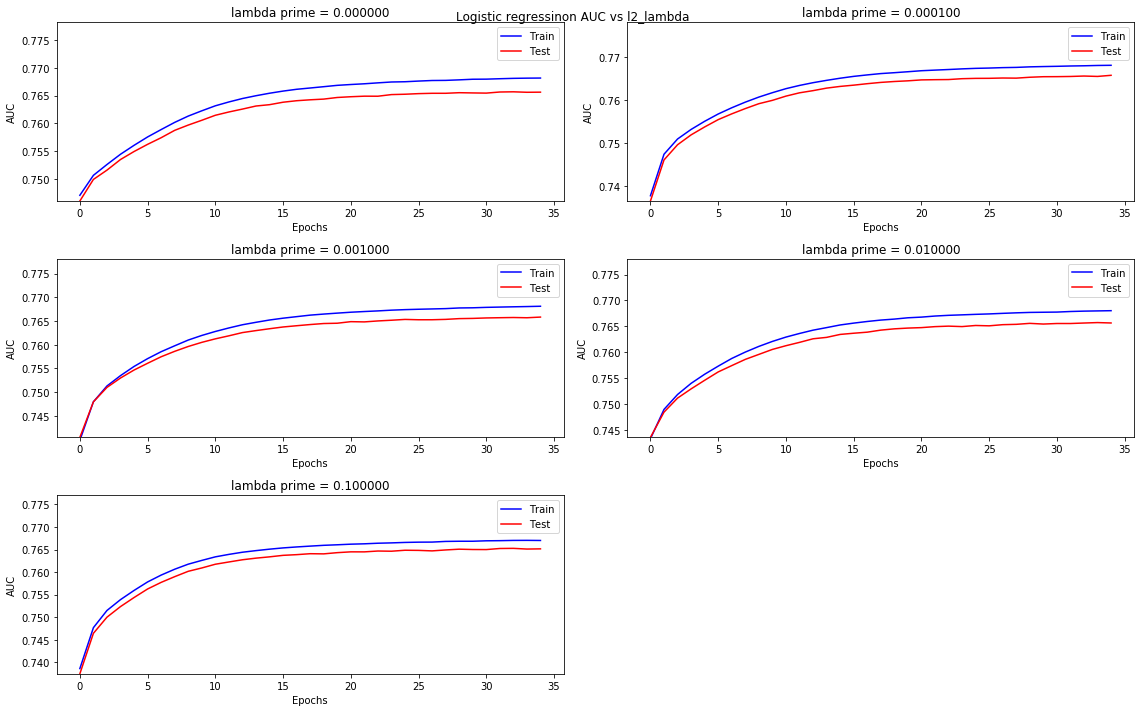

In [283]:
#%% visualizing and saving the cross validation results
auc_train_lr_avg = np.mean(auc_train_lr, axis = 2)
auc_val_lr_avg = np.mean(auc_val_lr, axis = 2)
#best model is chosen based on early stopping criterion, where the best model is chosen as the first epoch in which
#the val AUC (rounded to 4 decimal digits) == max val AUC rounded the same way
best_model_lr = np.argmax(auc_val_lr_avg[:,n_epoches-1])
best_epoch = np.argwhere(np.round(auc_val_lr_avg[best_model_lr,:],3) == np.round(
                                    np.max(auc_val_lr_avg[best_model_lr,:]),3))[0,0]
print('AUC train = ', np.max(auc_train_lr_avg[:,n_epoches-1]))
print('AUC validation = ', np.max(auc_val_lr_avg[:,n_epoches-1]))
print('Best L2 Lambda = {}, Best Epoch to stop training = {}'.format(l2_lambda[best_model_lr], 
                                                                     best_epoch))
#saving auc results to file
pd.DataFrame(auc_train_lr_avg).to_csv("auc_train_lr_avg.csv")
pd.DataFrame(auc_val_lr_avg).to_csv("auc_val_lr_avg.csv")

fig = plt.figure(figsize=(16, 10))
fig.suptitle("Logistic regressinon AUC vs l2_lambda")
for i in range(len(l2_lambda)):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(auc_train_lr_avg[i,:], c = 'b')
    plt.hold
    ax.plot(auc_val_lr_avg[i,:], c= 'r')
    plt.ylim((np.min(auc_val_lr_avg[i,:]), np.max(auc_train_lr_avg[i,:])+0.01))
    ax.set_title('lambda prime = {0:.6f}'.format(l2_lambda[i]))
    plt.legend(['Train', 'Test'])
    plt.ylabel('AUC')  
    plt.xlabel('Epochs')  
    plt.tight_layout()

### Retrain the best logistic regression classifier on the full training set

In [284]:
n_epoches = 35
auc_train_lr = np.zeros((n_epoches, 1))
auc_val_lr = np.zeros((n_epoches, 1))

In [285]:
with tf.Session(graph = graph_lr) as sess: 
    writer = tf.summary.FileWriter(logdir = "{}graph".format(pred_dir), graph = sess.graph)
    n_batches = math.ceil( y_tr.shape[0] / batch_size)
    sess.run(init_lr)
    for epoch in range(n_epoches):
        batch = generate_batch(X_tr_aug, y_tr, batch_size, shuffle = True)
        N = X_tr_aug.shape[0]
        for j in range(n_batches):
            data = next(batch)
            sess.run(training_ops_l2, feed_dict = {X_ph_aug: data[:,:-1], y_ph: data[:,-1].reshape(-1,1),
                                                    reg_lambda: l2_lambda[best_model_lr], 
                                                   learning_rate: 0.0005})                   
        p_train = sess.run(p_lr, feed_dict = { X_ph_aug: X_tr_aug, y_ph: y_tr,
                                              reg_lambda: l2_lambda[best_model_lr]})
        auc_train_lr[epoch] = roc_auc_score(y_true = y_tr, y_score = p_train, average = 'weighted')
        #for saving the model
        saver_lr.save(sess, '{}best_model_lr_l2_epoch_{}'.format(pred_dir, epoch))       

### Feature importance for best Logistic Regression classifier

INFO:tensorflow:Restoring parameters from D:\py\github\default payment/Logistc_Reg/best_model_lr_l2_epoch_28


Text(0.5,1,'feature importance logistic regression')

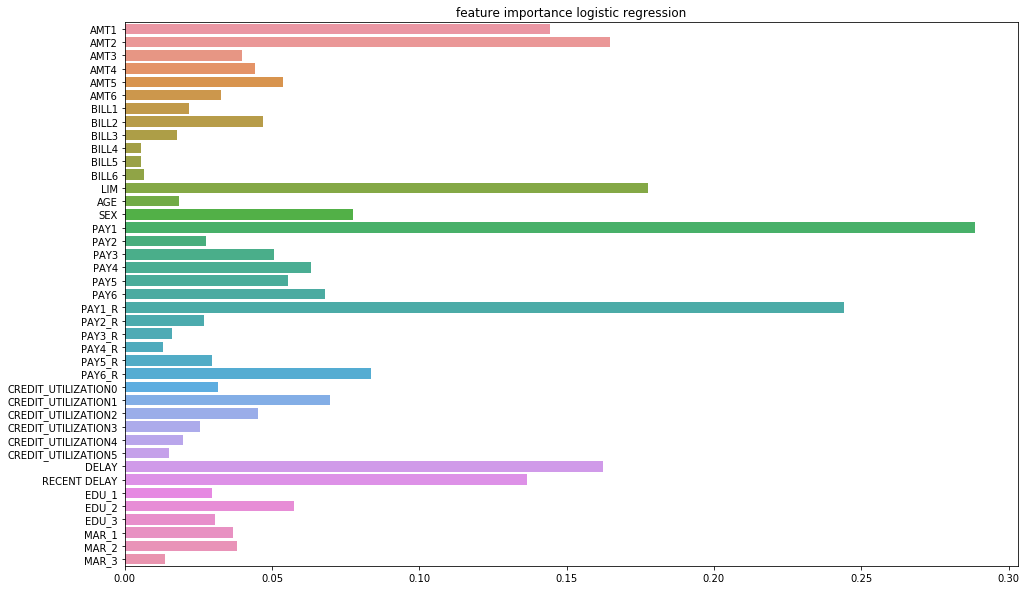

In [286]:
#restoring best logistic regression model
tf.reset_default_graph()
with tf.Session(graph = graph_lr) as sess:
    saver_lr.restore(sess, '{}best_model_lr_l2_epoch_{}'.format(pred_dir, best_epoch)) 
    w_lr = w.eval()
    #generate probability predictions on val and test sets
    prob_tr['LogisticReg'] = sess.run(p_lr, feed_dict = { X_ph_aug: X_tr_aug})
    prob_test['LogisticReg'] = sess.run(p_lr, feed_dict = { X_ph_aug: X_test_aug})
plt.figure(figsize = (16,10))
feat_importance_lr = np.abs(w_lr[1:]).squeeze() 
sns.barplot(feat_importance_lr, feats)
plt.title('feature importance logistic regression')


### 2-Neural Network Classifier

In [287]:
#creating the Neural Network graph
tf.reset_default_graph()
l1_output_units = 500
l2_output_units = 400
l3_output_units = 300
l4_output_units = 100
l5_output_units = 1
act_func = lambda x: tf.nn.leaky_relu(x, alpha = 0.3)
graph_nn = tf.Graph()
with graph_nn.as_default() as graph:
    with tf.variable_scope('nn', reuse = None) as scope_nn:
        X_ph = tf.placeholder(dtype = tf.float64, shape = [None, n_feats ], name = 'input')    
        y_ph = tf.placeholder(dtype = tf.float64, shape = [None, 1], name = 'label')
        reg_lambda = tf.placeholder(dtype = tf.float64, shape = [])
        kernel_reg = tf.contrib.layers.l2_regularizer(scale = reg_lambda)
        learning_rate = tf.placeholder(dtype = tf.float32, shape = [])
        training = tf.placeholder_with_default(False, shape = [], name = 'training_flag')
        args = {'num_out_units' : l1_output_units, 'activation' : act_func, 'regularizer' : kernel_reg, 
               'keep_prob' : 1, 'name' : 'L1', 'batch_norm' : False, 
               'training' : training, 'drop_out' : False, 'summary' : True}
        layer1 = fully_connected_layer(X_ph, **args)
        args.update({'num_out_units' : l2_output_units, 'name': 'L2'})
        layer2 = fully_connected_layer(layer1, **args)
        args.update({'num_out_units' : l3_output_units, 'name': 'L3'})
        layer3 = fully_connected_layer(layer2, **args)
        args.update({'num_out_units' : l4_output_units, 'name': 'L4'})
        layer4 = fully_connected_layer(layer3, **args)
        args.update({'num_out_units' : l5_output_units, 'act_func': None, 'name': 'L5'})
        layer5 = fully_connected_layer(layer4, **args)
        p_nn = tf.nn.sigmoid(layer5)#represents the prob of class 1
        y_hat_nn = tf.cast(tf.greater_equal(p_nn, 0.5), dtype = tf.float64) 
        weighted_loss_nn = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(pos_weight = pos_loss_weight,
                                                                                   targets = y_ph ,
                                                                                   logits = layer5 ))
        #to compute the regularization loss
        reg_loss_nn = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss_nn = weighted_loss_nn + tf.reduce_sum(reg_loss_nn)
        optimizer_nn = tf.train.AdamOptimizer(learning_rate = learning_rate)
        training_ops_nn = optimizer_nn.minimize(loss_nn)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(y_hat_nn, y_ph), tf.float64))  
        saver_nn = tf.train.Saver(max_to_keep = 1000)
        init_nn = tf.global_variables_initializer()

In [288]:
k = 5
batch_size = 512
n_epoches = 25
n_batches = math.ceil( y_tr.shape[0] / batch_size)
#l2 regularization constant grid
l2_lambda = np.concatenate((np.array([0]),np.logspace(-4, -1, 4))).astype(np.float64)
print(l2_lambda)
auc_train_nn = np.zeros((l2_lambda.shape[0], n_epoches, k))
auc_val_nn = np.zeros((l2_lambda.shape[0], n_epoches, k))
pred_dir = '{}/Neural_Network/'.format(cwd)
ensure_dir('{}'.format(pred_dir))

[0.     0.0001 0.001  0.01   0.1   ]


In [289]:
with tf.Session(graph = graph_nn) as sess:
    for i in range(len(l2_lambda)):
        l = 0
        for train_index, test_index in skf.split(X_tr_s, y_tr.squeeze()): 
            tf.set_random_seed(1)
            n_batches = math.ceil( y_tr[train_index].shape[0] / batch_size)
            sess.run(init_nn)
            for epoch in range(n_epoches):
                batch = generate_batch(X_tr_s[train_index], y_tr[train_index], batch_size, shuffle = True)
                for j in range(n_batches):
                    data = next(batch)
                    sess.run([training_ops_nn], feed_dict = {X_ph: data[:,:-1], 
                                                             y_ph: data[:,-1].reshape(-1,1),
                                                             reg_lambda: l2_lambda[i], 
                                                             learning_rate: 0.0001, 
                                                             training: True})

                y_score_train = sess.run(p_nn, feed_dict = {X_ph: X_tr_s[train_index], 
                                                            y_ph: y_tr[train_index].reshape(-1,1)})
                y_score_val = sess.run(p_nn, feed_dict = {X_ph: X_tr_s[test_index], y_ph: 
                                                          y_tr[test_index].reshape(-1,1)})
                auc_train_nn[i, epoch, l]  = roc_auc_score(y_true = y_tr[train_index], 
                                                           y_score = y_score_train, 
                                                           average = 'weighted')
                auc_val_nn[i, epoch, l]  = roc_auc_score(y_true = y_tr[test_index], 
                                                         y_score = y_score_val, 
                                                         average = 'weighted')
                #for saving the model
                saver_nn.save(sess, '{}/model_nn_l2_{}_epoch_{}'.format(pred_dir, i, epoch)) 
            l+=1

AUC train =  0.8077116953401955
AUC validation =  0.779924815143614
Best L2 Lambda = 0.001, Best Epoch to stop training = 21


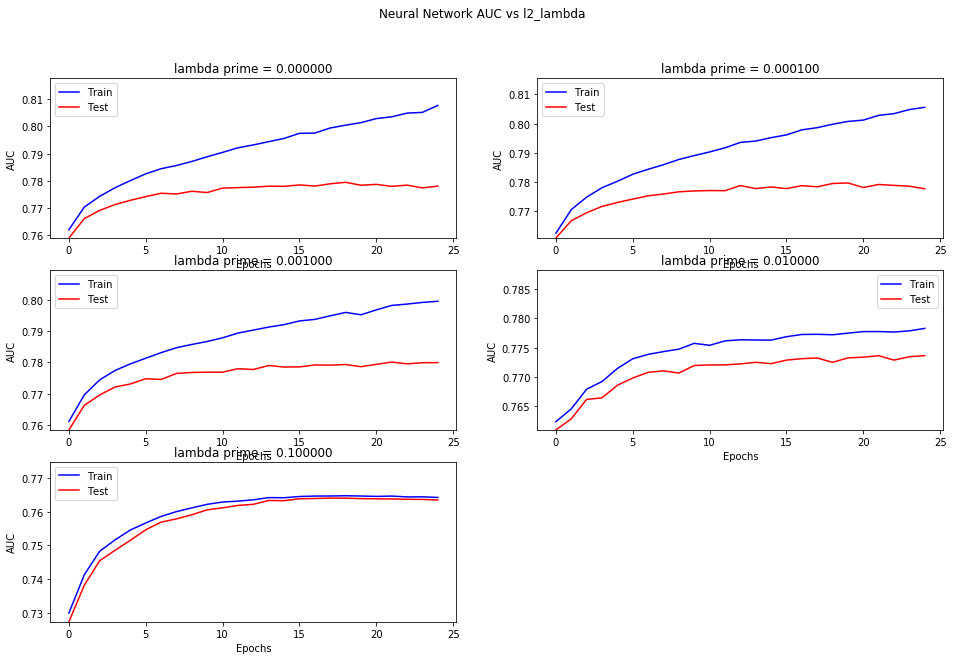

In [290]:
#%% visualizing and scaving the cross validation results
auc_train_nn_avg = np.mean(auc_train_nn, axis = 2)
auc_val_nn_avg = np.mean(auc_val_nn, axis = 2)
best_model_nn = np.argmax(auc_val_nn_avg[:,n_epoches-1])
best_epoch_nn = np.argwhere(np.round(auc_val_nn_avg[best_model_nn,:],3) >= np.round(
                                    np.max(auc_val_nn_avg[best_model_nn,:]),3))[0,0]
print('AUC train = ', np.max(auc_train_nn_avg[:,n_epoches-1]))
print('AUC validation = ', np.max(auc_val_nn_avg[:,n_epoches-1]))
print('Best L2 Lambda = {}, Best Epoch to stop training = {}'.format(l2_lambda[best_model_nn], 
                                                                     best_epoch_nn))
#saving auc results to file
pd.DataFrame(auc_train_nn_avg).to_csv("{}auc_train_lr_avg.csv".format(pred_dir))
pd.DataFrame(auc_val_nn_avg).to_csv("{}auc_val_lr_avg.csv".format(pred_dir))

fig = plt.figure(figsize=(16, 10))
fig.suptitle("Neural Network AUC vs l2_lambda")
for i in range(len(l2_lambda)):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(auc_train_nn_avg[i,:], c = 'b')
    plt.hold
    ax.plot(auc_val_nn_avg[i,:], c= 'r')
    plt.ylim((np.min(auc_val_nn_avg[i,:]), np.max(auc_train_nn_avg[i,:])+0.01))
    ax.set_title('lambda prime = {0:.6f}'.format(l2_lambda[i]))
    plt.legend(['Train', 'Test'])
    plt.ylabel('AUC')  
    plt.xlabel('Epochs')  

### Retrain the neural network with the best l2 lambda on the full training set

In [291]:
n_epoches = 25
auc_train_nn  = np.zeros((n_epoches, 1))
auc_val_nn  = np.zeros((n_epoches, 1))

In [292]:
with tf.Session(graph = graph_nn) as sess: 
    writer = tf.summary.FileWriter(logdir = "{}graph".format(pred_dir), graph = sess.graph)
    n_batches = math.ceil( y_tr.shape[0] / batch_size)
    sess.run(init_nn)
    for epoch in range(n_epoches):
        batch = generate_batch(X_tr_s, y_tr, batch_size, shuffle = True)
        N = X_tr_aug.shape[0]
        for j in range(n_batches):
            data = next(batch)
            sess.run(training_ops_nn, feed_dict = {X_ph: data[:,:-1], y_ph: data[:,-1].reshape(-1,1),
                                                    reg_lambda: l2_lambda[best_model_nn], 
                                                   learning_rate: 0.0001})
                   
        p_train = sess.run(p_nn, feed_dict = { X_ph: X_tr_s, y_ph: y_tr, 
                                              reg_lambda: l2_lambda[best_model_nn]})
        auc_train_nn[epoch] = roc_auc_score(y_true = y_tr, y_score = p_train, average = 'weighted')
        #for saving the model
        saver_nn.save(sess, '{}best_model_nn_l2_epoch_{}'.format(pred_dir, epoch))

### Feature importance for best Neural Network model

According to [2] the feature importance for a neural network can be estimated as follows:
<br>• Wij = weight from each feature i to unit j in the first layer
<br>• a = Sum(wij ^2 ) across all first layer units j, the result will be vector of length = number of features
<br>• feature importance = sqrt(a)/sum(sqrt(a))

INFO:tensorflow:Restoring parameters from D:\py\github\default payment/Neural_Network/best_model_nn_l2_epoch_21


Text(0.5,1,'feature importance Neural Network')

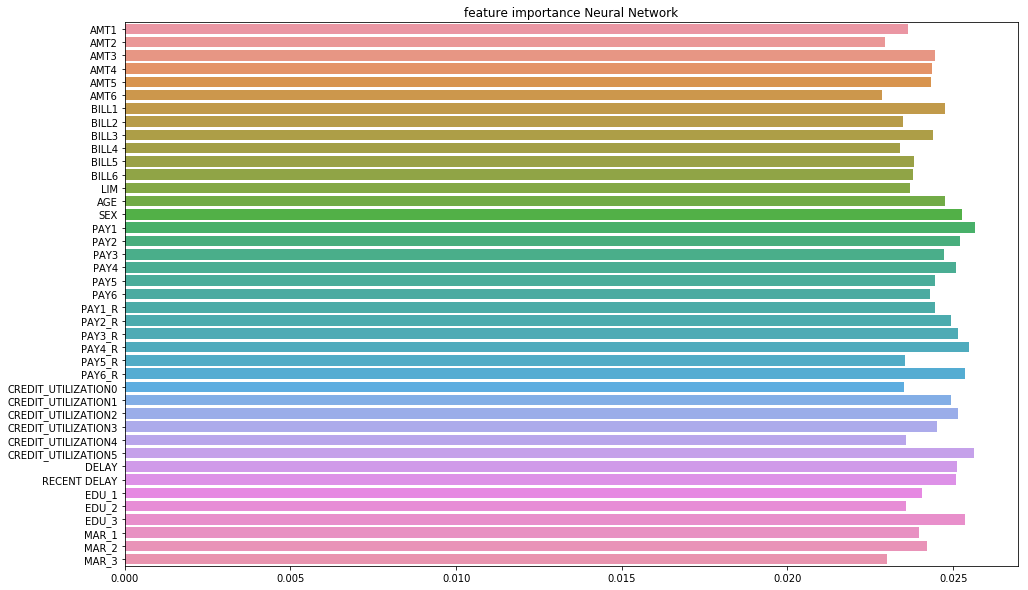

In [293]:
tf.reset_default_graph()
with tf.Session(graph = graph_nn) as sess:
    saver_nn.restore(sess, '{}best_model_nn_l2_epoch_{}'.format(pred_dir, best_epoch_nn))  
    #var = tf.trainable_variables()
    w_l1_nn = [var for var in tf.trainable_variables() 
               if var.name == 'nn/L1/fully_connected/weights:0'][0].eval()
    y_score_val_nn = sess.run(p_nn, feed_dict = { X_ph: X_val_s})
    y_score_val_nn = sess.run(p_nn, feed_dict = { X_ph: X_val_s})

w_l1_nn =np.sqrt(np.sum( w_l1_nn * w_l1_nn, axis = 1))
feat_importance_nn = w_l1_nn/np.sum(w_l1_nn)  
plt.figure(figsize = (16, 10))
sns.barplot(feat_importance_nn, feats)
plt.title('feature importance Neural Network')

### 3-Random Forest

In [294]:
#Random forest hyperparameters grids
num_estimators = np.arange(50, 250, 50)
max_depth = [3, 4, 5, 6, 7]
#min_samples_split was set to 30 to prevent overfitting 
#max features was set to 0.6 to reduce the correlataion between 
#constructed trees
auc_train_rnd = np.zeros((len(num_estimators), len(max_depth), k))
auc_val_rnd = np.zeros((len(num_estimators), len(max_depth), k))

rnd_forest_clf = dict()
for i in range(len(num_estimators)):
    for j in range(len(max_depth)):
        l = 0
        for train_index, test_index in skf.split(X_tr, y_tr.squeeze()): 
            name = '{}{}'.format(i,j)
            rnd_forest_clf[name] = RandomForestClassifier(n_estimators = num_estimators[i], 
                                                          criterion = 'gini', max_depth = max_depth[j], 
                                                          random_state = 0, max_features = 0.6, 
                                                          class_weight = {0: 1, 1: pos_loss_weight},
                                                          min_samples_split = 30)
        
            rnd_forest_clf.get(name).fit(X_tr[train_index], y_tr[train_index].squeeze())
            #score using prob of pos class
            y_score_train = rnd_forest_clf.get(name).predict_proba(X_tr[train_index])[:,1] 
            auc_train_rnd[i, j, l] = roc_auc_score(y_true = y_tr[train_index].squeeze(),
                                                   y_score = y_score_train, average = 'weighted')
            y_score_test = rnd_forest_clf.get(name).predict_proba(X_tr[test_index])[:,1] 
            auc_val_rnd[i, j, l] = roc_auc_score(y_true = y_tr[test_index].squeeze(), 
                                                 y_score = y_score_test, average = 'weighted')
            l+=1

best number of estimator = 150,   best max depth = 6
auc train = 0.8132828684600018
auc validation = 0.7835005406066728


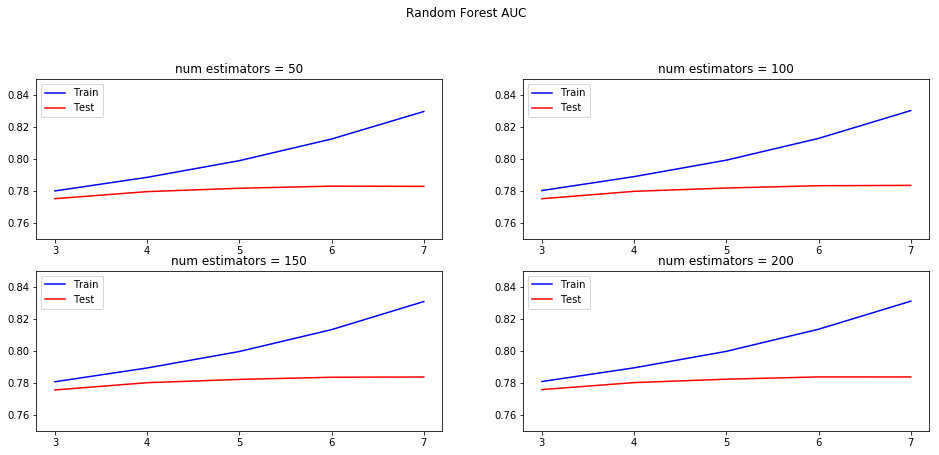

In [295]:
pred_dir = '{}/Random_Forest/'.format(cwd)
ensure_dir('{}'.format(pred_dir))
#saving the models to file
save_obj(rnd_forest_clf, '{}_Random_Forest_classifiers'.format(pred_dir))
auc_train_rnd_avg = np.mean(auc_train_rnd, axis = 2)
auc_val_rnd_avg = np.mean(auc_val_rnd, axis = 2)
pd.DataFrame(auc_train_rnd_avg).to_csv("auc_train_rnd_avg.csv")
pd.DataFrame(auc_val_rnd_avg).to_csv("auc_val_rnd_avg.csv")
best_model_rnd = np.argwhere(auc_val_rnd_avg == auc_val_rnd_avg.max())[0]
best_model_rnd  =np.argwhere(np.round(auc_val_rnd_avg, 3) == np.max(np.round(auc_val_rnd_avg, 3)))[0]
print('best number of estimator = {},   best max depth = {}'.format(num_estimators[best_model_rnd[0]], 
                                                                    max_depth[best_model_rnd[1]]))
print('auc train =', auc_train_rnd_avg[best_model_rnd[0], best_model_rnd[1]])
print('auc validation =', auc_val_rnd_avg[best_model_rnd[0], best_model_rnd[1]])

fig = plt.figure(figsize = (16, 10))
fig.suptitle("Random Forest AUC ")
for i in range(len(num_estimators)):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(max_depth, auc_train_rnd_avg[i, :], c = 'b')
    plt.hold
    ax.plot(max_depth, auc_val_rnd_avg[i, :], c= 'r')
    plt.title('num estimators = {}'.format(num_estimators[i]))
    plt.xticks(max_depth )
    plt.ylim((0.75, 0.85))
    plt.legend(['Train', 'Test'])

### Retrain the best Random Forset Classifier on the full training set

In [297]:
best_rnd = "{}{}".format(best_model_rnd[0], best_model_rnd[1])
rnd_forest_clf.get(best_rnd).fit(X_tr, y_tr.squeeze())
y_score_train = rnd_forest_clf.get(best_rnd).predict_proba(X_tr)[:,1] #score using prob of pos class
auc_rnd = roc_auc_score(y_true = y_tr.squeeze(), y_score = y_score_train, average = 'weighted')

### Feature importance for best Random Forest model

Text(0.5,1,'feature importance Random Forest')

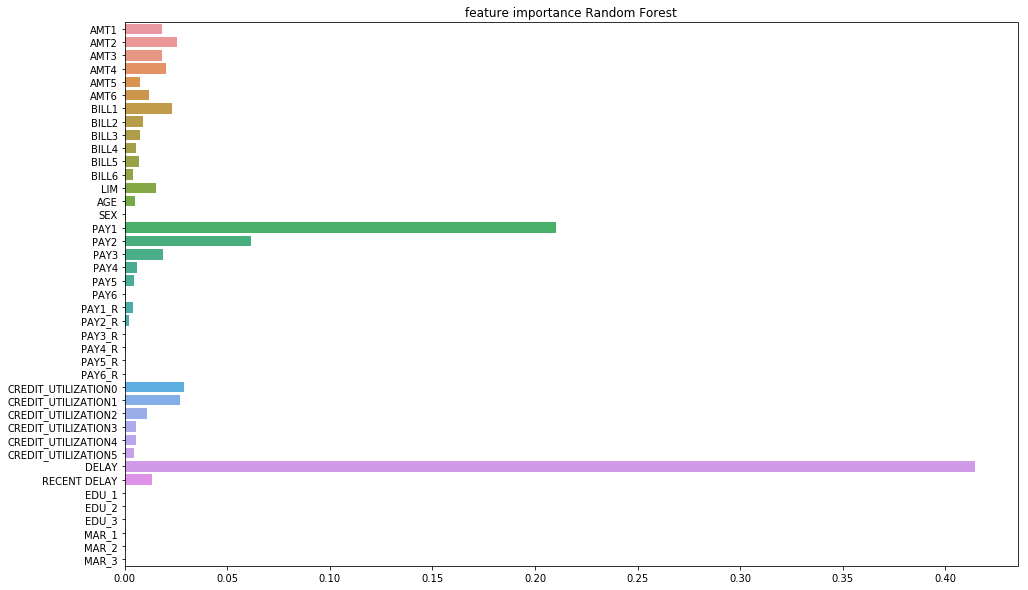

In [298]:
feat_importance_rnd = rnd_forest_clf.get('{}{}'.format(best_model_rnd[0],
                                                       best_model_rnd[1])).feature_importances_
plt.figure(figsize = (16, 10))
sns.barplot(feat_importance_rnd, feats) 
plt.title('feature importance Random Forest')

### 4-XGBoost

In [20]:
sample_weight = np.ones(y_tr.shape)
sample_weight[y_tr == 1] = pos_loss_weight
#XGBoost hyperparameters grid
num_estimators = np.arange(100, 600, 50)
max_depth = [2,3,4]
#the following paramters were chosen to reduce the possibility of overfitting
#number of features used to train each tree is set to 40% number of features,
#to reduce the correlation between correlated trees
#the same for the number of samples using for training each tree
#min samples per leaves increased to 30
auc_train_xgb = np.zeros((len(num_estimators), len(max_depth), k))
auc_val_xgb = np.zeros((len(num_estimators), len(max_depth), k))
param = {
        'objective': 'gpu:binary:logistic',
        'max_depth': 1,
        'n_estimators': 1,      
        'colsample_bytree' : 0.4,
        'subsample': 0.4,
        'seed': 7,
        'min_samples_leaf':30,
        'silent': 1,
        'eval_metric':'auc',
        'learning_rate':  0.01,    
        'tree_method': 'gpu_exact'
        }

xgb_clf = dict()
for i in range(len(num_estimators)):
    for j in range(len(max_depth)):
        param.update({'n_estimators': num_estimators[i], 'max_depth': max_depth[j]})
        clf = xgb.XGBClassifier(**param)
        l = 0
        for train_index, test_index in skf.split(X_tr, y_tr.squeeze()):             
            clf.fit(X_tr[train_index], y_tr[train_index].squeeze(), sample_weight = sample_weight)
            y_score_train = clf.predict_proba(X_tr[train_index])[:,1]
            y_score_test = clf.predict_proba(X_tr[test_index])[:,1]
            auc_train_xgb[i, j, l] = roc_auc_score(y_true = y_tr[train_index].squeeze(), 
                                                   y_score = y_score_train.squeeze(), average = 'weighted')
            auc_val_xgb[i, j, l] = roc_auc_score(y_true = y_tr[test_index].squeeze(), 
                                                 y_score = y_score_test.squeeze(), average = 'weighted')
            l += 1 
        xgb_clf['{}{}'.format(i, j)] = clf

best number of estimator = 500,   best max depth = 4
auc train = 0.8110696830289467
auc validation = 0.7836006750786624


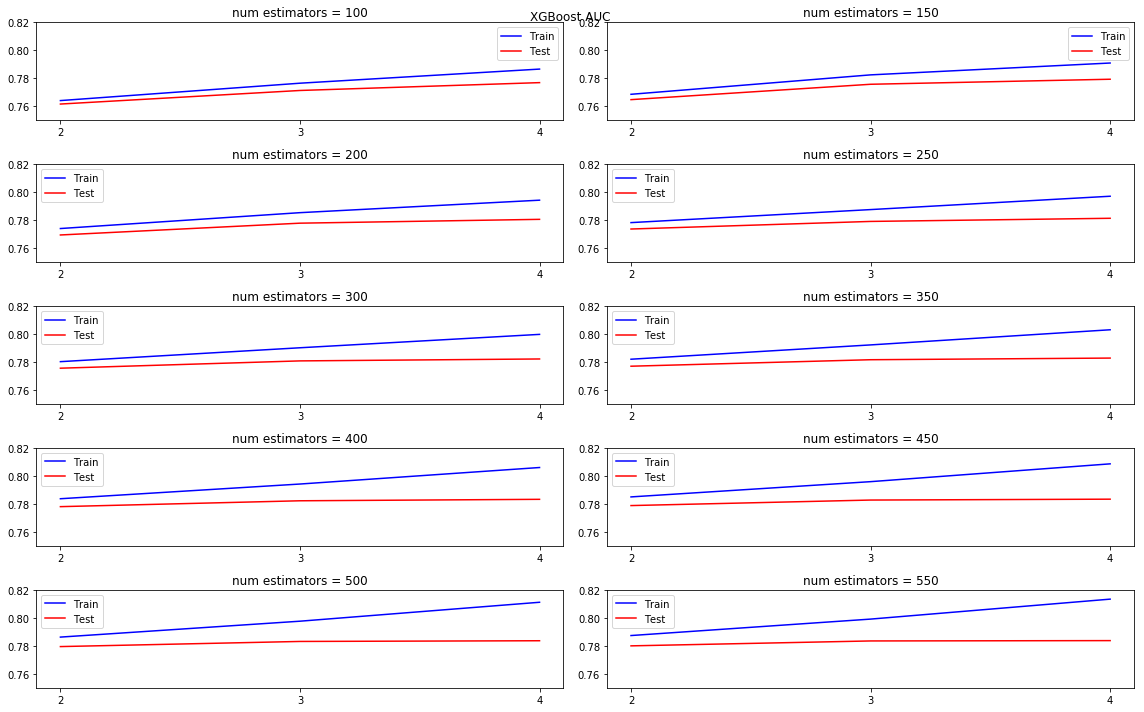

In [26]:
pred_dir = '{}/XGBoost/'.format(cwd)
ensure_dir('{}'.format(pred_dir))
#saving the models to file
save_obj(xgb_clf, '{}_XGBoost_classifiers'.format(pred_dir))
auc_train_xgb_avg = np.mean(auc_train_xgb, axis = 2)
auc_val_xgb_avg = np.mean(auc_val_xgb, axis = 2)
pd.DataFrame(auc_train_xgb_avg).to_csv("auc_train_xgb_avg.csv")
pd.DataFrame(auc_val_xgb_avg).to_csv("auc_val_xgb_avg.csv")
best_model_xgb = np.argwhere(auc_val_xgb_avg == auc_val_xgb_avg.max())[0]
best_model_xgb  =np.argwhere(np.round(auc_val_xgb_avg, 3) == np.max(np.round(auc_val_xgb_avg, 3)))[0]
print('best number of estimator = {},   best max depth = {}'.format(num_estimators[best_model_xgb[0]],
                                                                    max_depth[best_model_xgb[1]]))
print('auc train =', auc_train_xgb_avg[best_model_xgb[0], best_model_xgb[1]])
print('auc validation =', auc_val_xgb_avg[best_model_xgb[0], best_model_xgb[1]])

fig = plt.figure(figsize = (16, 10))
fig.suptitle("XGBoost AUC ")
for i in range(len(num_estimators)):
    ax = plt.subplot(5, 2, i+1)
    ax.plot(max_depth, auc_train_xgb_avg[i, :], c = 'b')
    plt.hold
    ax.plot(max_depth, auc_val_xgb_avg[i, :], c= 'r')
    plt.title('num estimators = {}'.format(num_estimators[i]))
    plt.xticks(max_depth)
    plt.ylim((0.75, 0.82))
    plt.legend(['Train', 'Test'])
    plt.tight_layout()

### Retrain the best XGBoost Classifier on the full training set

In [29]:
best_xgb = "{}{}".format(best_model_xgb[0], best_model_xgb[1])
xgb_clf.get(best_xgb).fit(X_tr, y_tr.squeeze())
y_score_train = xgb_clf.get(best_xgb).predict_proba(X_tr)[:,1] #score using prob of pos class
auc_xgb = roc_auc_score(y_true = y_tr.squeeze(), y_score = y_score_train, average = 'weighted')
#generate probability predictions on training and test sets
prob_tr['XGBoost'] = xgb_clf.get(best_xgb).predict_proba(X_tr)[:,1] 
prob_test['XGBoost'] = xgb_clf.get(best_xgb).predict_proba(X_test)[:,1] 

### Feature importance for best XGBoost model

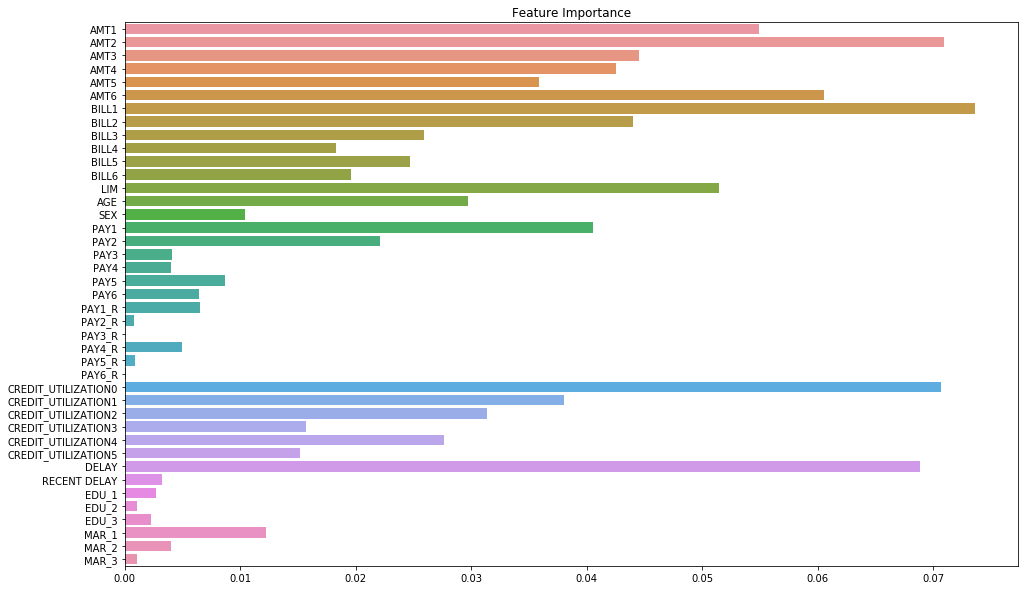

In [30]:
feat_importance = xgb_clf[best_xgb].feature_importances_
feat_importance = pd.DataFrame(data = feat_importance, columns = ['feature_importance'], 
                               index = df.columns[:-1])      
plt.figure(figsize = (16, 10))
plt.title('Feature Importance')
sns.barplot(x = feat_importance.values.squeeze(), y = feat_importance.index.tolist())

### Evaluate the performance of the best classifier on the final test set

The 5-folds cross validation shows that the best classifier is the XGBoost model with a max depth of 4 and number of estimators of 500.
<br>Now, the final step is to check the generalization of the performance on out of sample data (unseen data) which has not been used in any way for training or validation

AUC test:  0.781718512818189


Text(0.5,0,'False positive rate')

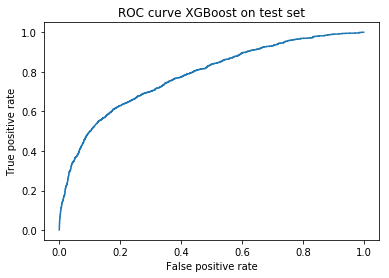

In [37]:
#generate probability predictions on Final test sets
prob_test_xgb = xgb_clf.get(best_xgb).predict_proba(X_test)[:,1] 
auc_test_xgb = roc_auc_score(y_true = y_test.squeeze(), y_score = prob_test_xgb.squeeze(), 
                             average = 'weighted')
fpr_test, tpr_test,_ = roc_curve(y_true = y_test.squeeze(), y_score = prob_test_xgb.squeeze(), 
                                 pos_label = 1, drop_intermediate = False)
print("AUC test: ", auc_test_xgb)
plt.title("ROC curve XGBoost on test set")
plt.plot(fpr_test, tpr_test)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

With probability of 1- sigma, the AUCout will be within 
#### <br>sqrt(ln(2∗𝑀/𝑠𝑖𝑔𝑚𝑎))/(2∗𝑁∗𝜌(𝑦)(1−𝜌(𝑦))              [3]
<br>from the AUCin. Where
<br>• M is the number of models in the hypothesis set
<br>• N number of samples
<br>• 𝜌(𝑦) = positive class rate
<br>• AUCin = in-sample AUC
<br>• AUCout = out-of-sample AUC

The AUC out of sample bound can be computed using final test data, N = 6000, M=1, and sigma = 0.05. As a result, the out of samples AUC will be within 0.042 from AUCtest with probability >= 0.95

### References:
<br>1- https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset
<br>2- Jeff Heaton, Steven McElwee, James Cannady, James Fraley (2017). Early Stabilizing Feature Importance for TensorFlow Deep Neural Networks
<br>3- Shivani Agarwal, Thore Graepel , Ralf Herbrich , Sariel Har-Peled and Dan Roth (2004). Generalization Bounds for the Area Under an ROC Curve
